# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [1]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import numpy as np
import pandas
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score


## ```Cyclist``` Dataset

In [2]:
# Assuming the dataset is in a CSV file named 'cyclists.csv'
cyclists_df = pandas.read_csv('../dataset/cyclists_outlier.csv')

numeric_columns = cyclists_df.select_dtypes(include=[np.number]).columns

# Specify the columns to keep
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

#### **Features normalization**


Standardize cyclists_df by scaling each feature to have a mean of 0 and a standard deviation of 1.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cyclists_df[columns_to_keep])
cyclist_normalized_df = scaler.transform(cyclists_df[columns_to_keep])


In [4]:
start_centroids = 2
random_state = 42  # Set the seed for the random number generator

# Initialize the centers with K-Means++ using the seed
initial_centers = kmeans_plusplus_initializer(cyclist_normalized_df, start_centroids, random_state=random_state).initialize()

# Run X-Means using the same seed
x_means = xmeans(
    cyclist_normalized_df, 
    initial_centers, 
    kmax=5, 
    tolerance=1.5, 
    repeat=50, 
    random_state=random_state, 
    ccore=False,
    criterion=0     # BIC criterion
)
x_means.process()

In [5]:
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centers = x_means.get_centers()

for i, cluster in enumerate(clusters):
    print(f"Cluster {i} shape: {len(cluster)}")

Cluster 0 shape: 2182
Cluster 1 shape: 685
Cluster 2 shape: 609


Extracting labels from clusters

In [6]:
n_clusters = len(clusters)
labels = {index: cluster_label for cluster_label, cluster in enumerate(clusters) for index in cluster}

xmeans_labels = [labels[i] for i in sorted(labels)]


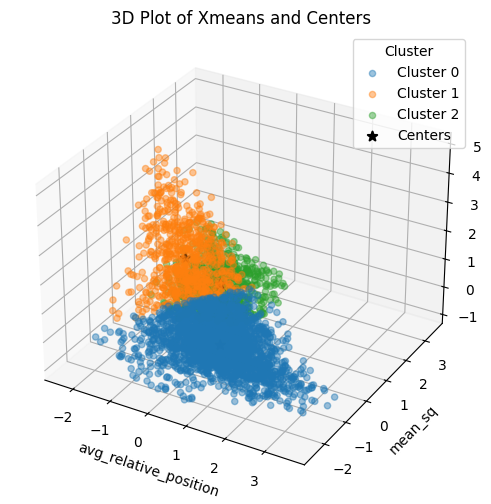

In [7]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters with transparency
for cluster_label, cluster in enumerate(clusters):
    points = cyclist_normalized_df[cluster]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.44, label=f'Cluster {cluster_label}')

# Plot the centers with a distinct color and larger marker size
centers = np.array(centers)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', marker='*', s=50, alpha=1, edgecolors='black', linewidths=1.5, label='Centers')

ax.set_xlabel(columns_to_keep[0])
ax.set_ylabel(columns_to_keep[1])
ax.set_zlabel(columns_to_keep[2])
plt.title('3D Plot of Xmeans and Centers')
plt.legend(title='Cluster')
plt.show()


PCA CLUSTER ANALYSIS

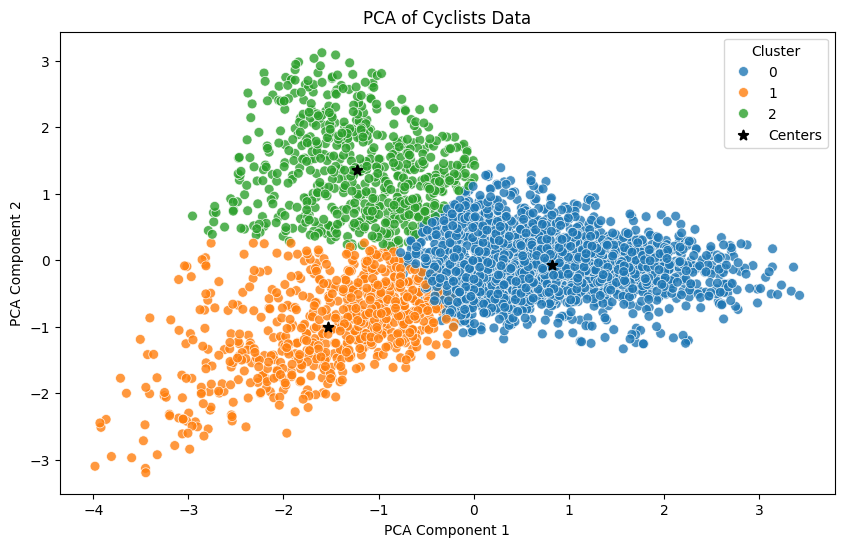

In [8]:
# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(cyclist_normalized_df)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = xmeans_labels

# Transform the centers to the PCA space
centers_pca = pca.transform(centers)

# Plot the PCA components with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=50, alpha=0.8)

# Plot the centers
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='*', s=50, edgecolors='black', linewidths=1.5, label='Centers')

plt.title('PCA of Cyclists Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

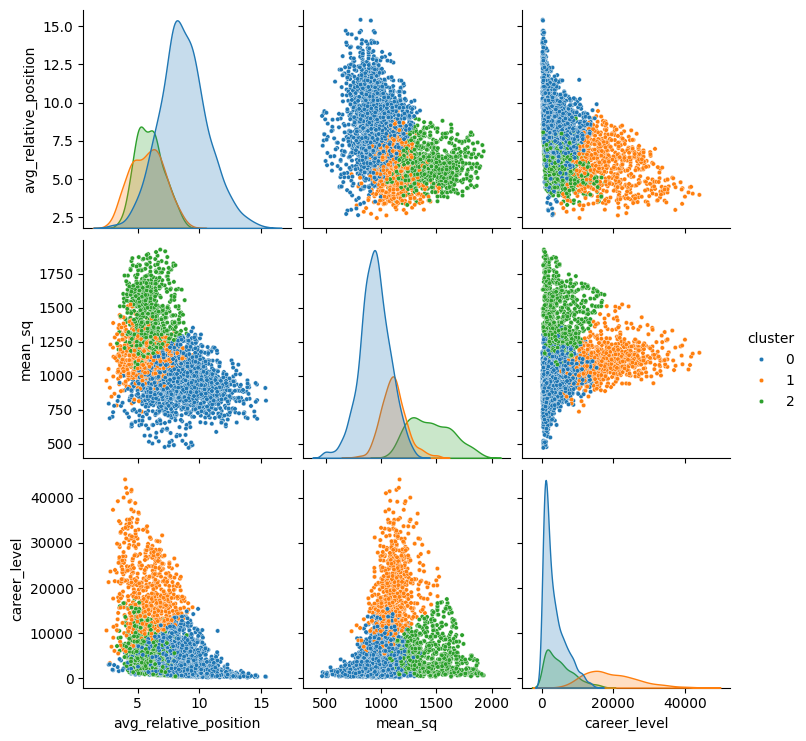

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = x_means.predict(cyclist_normalized_df)
labels = pandas.DataFrame(labels, columns=["cluster"])

cyclist_normalized_df_with_labels = pandas.DataFrame(cyclist_normalized_df, columns=cyclists_df[columns_to_keep].columns)
cyclist_normalized_df_with_labels["cluster"] = labels["cluster"]

# Combine the normalized data with the original data
combined_df = pandas.concat([cyclists_df, cyclist_normalized_df_with_labels["cluster"]], axis=1)

# Create a pairplot
sns.pairplot(combined_df, hue="cluster", vars=columns_to_keep, palette="tab10", plot_kws={'s': 10, 'alpha': 1.0})
plt.show()



In [10]:
print('Davies Bouldin Score: \t%s' % davies_bouldin_score(cyclist_normalized_df, xmeans_labels)) # lower value, better clustering (minimum zero)
print('Silhouette: \t\t%s' % silhouette_score(cyclist_normalized_df, xmeans_labels))

Davies Bouldin Score: 	0.8664175633191243
Silhouette: 		0.4170001870686073


Plot of cluster labels distribution

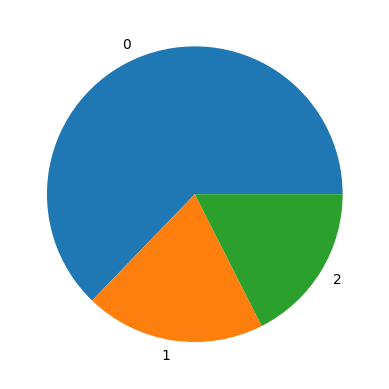

In [11]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))
    
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

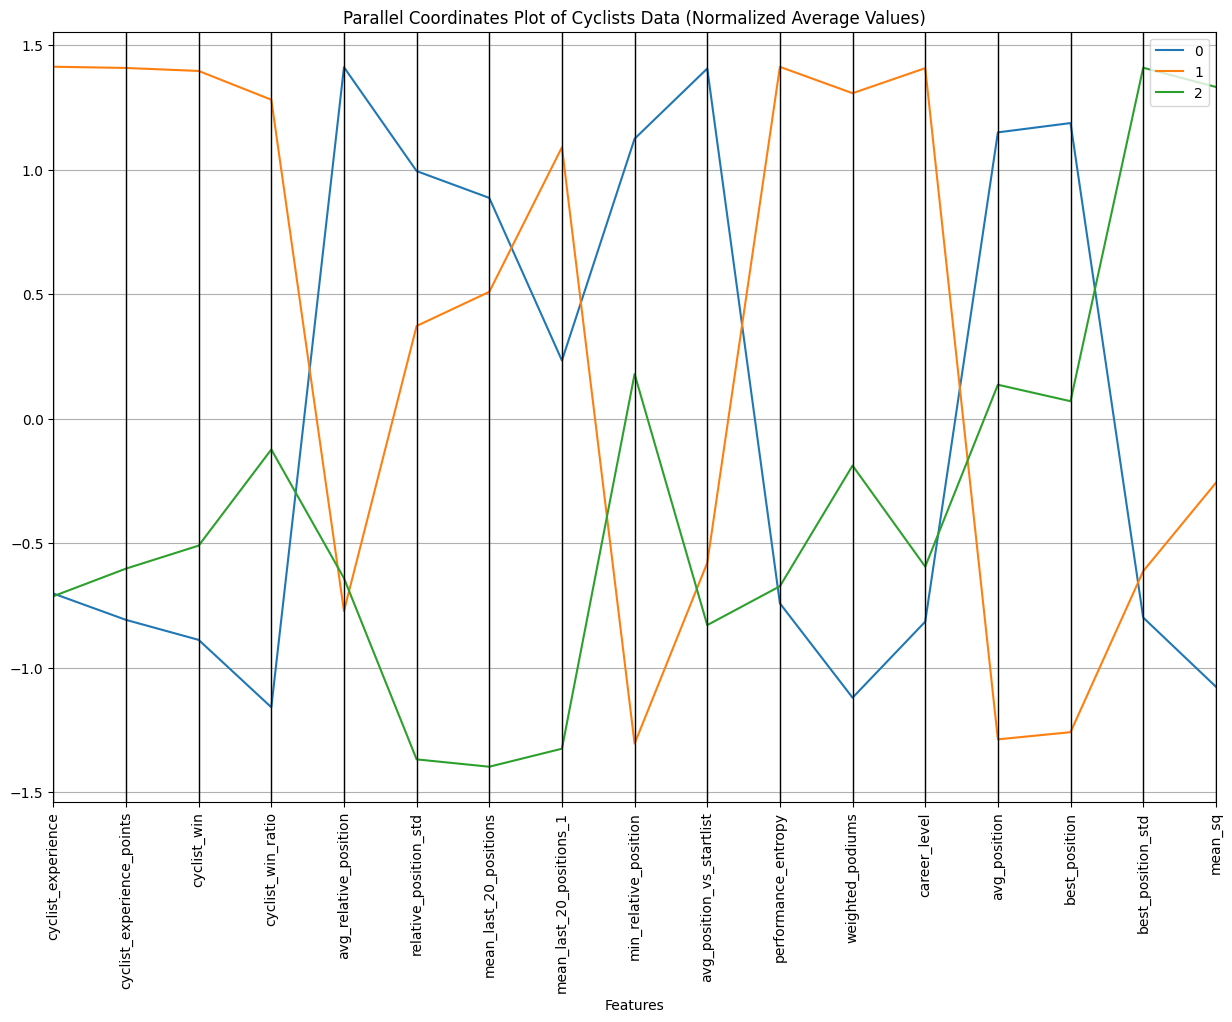

In [25]:
from pandas.plotting import parallel_coordinates

# Calculate the average values for each cluster
temp_df = cyclists_df[numeric_columns].assign(cluster=labels["cluster"])
average_values = temp_df.groupby('cluster')[numeric_columns].mean().reset_index()

# Normalize the average values
scaler = StandardScaler()
average_values_normalized = scaler.fit_transform(average_values[numeric_columns])

# Create a DataFrame for the normalized average values
average_values_normalized_df = pd.DataFrame(average_values_normalized, columns=numeric_columns)
average_values_normalized_df['cluster'] = average_values['cluster']


# Create a parallel coordinates plot
plt.figure(figsize=(15, 10))
parallel_coordinates(average_values_normalized_df.drop(columns=['birth_year']), class_column='cluster', color=sns.color_palette('tab10', n_clusters))
plt.title('Parallel Coordinates Plot of Cyclists Data (Normalized Average Values)')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()